# iLykei Lecture Series

# Machine Learning

# Introduction to Deep Learning

# Tuning Nets with Keras

## Yuri Balasanov, Leonid Nazarov, &copy; iLykei 2017-2020


This notebook shows how to tune basic network parameters: number of epochs, dropout rate, learning rate, number of neurons in the layers, optimization algorithm.

Import all necessary modules.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import to_categorical, plot_model
from keras.optimizers import Adam,SGD,Adagrad
from keras.utils.vis_utils import model_to_dot
from keras.wrappers.scikit_learn import KerasClassifier
from IPython.display import SVG


Using TensorFlow backend.
/home/yuri/anaconda3/envs/tfspecial/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/yuri/anaconda3/envs/tfspecial/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/yuri/anaconda3/envs/tfspecial/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/yuri/anacon

# Data (Kaggle OTTO  Group challenge)

Tuning methods will be demonstrated on the train dataset from Kaggle [Otto Group Product Classification Challenge](https://www.kaggle.com/c/otto-group-product-classification-challenge).  
Read the data, remove 'id' column and shuffle rows since they are originally oredered by class. 

In [2]:
X = pd.read_csv("KaggleOtto_train.csv")
X.drop('id', axis=1, inplace=True)
print(X.shape)
np.random.seed(1)
# Shuffle data. It is originally oredered by class
X = X.reindex(np.random.permutation(X.index))

(55878, 94)


This is a multiclass classification problem. 

Keras loss function for this problem is `categorical_crossentropy` (multiclass logloss). 

There is important note in the manual:  <br>
when using the `categorical_crossentropy` loss, your targets should be in categorical format (e.g. if you have 10 classes, the target for each sample should be a 10-dimensional vector that is all-zeros except for 1 at the index corresponding to the class of the sample). 

In order to convert integer targets into categorical targets, you can use Keras utility `to_categorical`:

`from keras.utils import to_categorical`
`categorical_labels = to_categorical(int_labels, num_classes=None)`

The target variable initially is in string format:

In [3]:
X.target[:6]

34888    Class_8
33063    Class_1
18402    Class_5
48904    Class_9
8078     Class_3
24224    Class_6
Name: target, dtype: object

Convert strings to integers and then to categorical format

In [4]:
# Extract target
# Encode it to make it manageable by ML algo, convert to np.int32
y = X.target.values
encoder = LabelEncoder()
y = encoder.fit_transform(y).astype(np.int32)
num_classes = len(encoder.classes_)
# convert class vectors to binary class matrices
y = to_categorical(y, num_classes)

# Remove target from train
X.drop('target', axis=1, inplace=True)

y[:6,:]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

It was noticed during competition that logarithmic transfrom improves performance of most of ML algrithms. Transform the data and convert them to numpy array.

In [5]:
num_features = X.shape[1]
# log transform to decrease large values affect
X = np.log(1+X.values)

# The baseline model

Start tunning sequential network with two hidden layers and dropout layers after each of them. 

The following function creates such network.

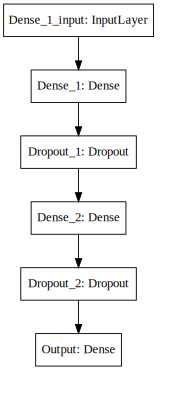

In [25]:
def getModel(dropout=0.1, neurons1=500, neurons2=250,
             learningRate=0.04):
    np.random.seed(1)
    model = Sequential()
    model.add(Dense(neurons1, activation='relu', input_dim=num_features,
                    name='Dense_1'))
    model.add(Dropout(dropout,name='Dropout_1'))
    model.add(Dense(neurons2, activation='relu',name='Dense_2'))
    model.add(Dropout(dropout,name='Dropout_2'))
    model.add(Dense(num_classes, activation='softmax',name='Output'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adagrad(lr=learningRate), metrics=['accuracy'])
    return model

model1 = getModel()

SVG(model_to_dot(model1,dpi=65).create(prog='dot', format='svg'))

The network was created by `getModel()` with default parameters. Method `Fit` has parameter  

`validation_split`: float (0. < x < 1): this is fraction of the data to use as hold-out validation data.  

Set `validation_split = 0.2` i.e. 20% of data will be used for validation. <br>
Fit the model and draw validation loss plot. <br>
Since we want to show validation loss behaviour after it reaches minimum, we do not use `EarlyStopping` callback.

In [7]:
net1 = model1.fit(X, y, epochs=12, batch_size=512, verbose=2,
                  validation_split=0.2)


Train on 44702 samples, validate on 11176 samples
Epoch 1/12
 - 1s - loss: 0.9565 - accuracy: 0.7123 - val_loss: 0.6122 - val_accuracy: 0.7643
Epoch 2/12
 - 1s - loss: 0.5570 - accuracy: 0.7856 - val_loss: 0.5701 - val_accuracy: 0.7810
Epoch 3/12
 - 1s - loss: 0.5123 - accuracy: 0.8028 - val_loss: 0.5388 - val_accuracy: 0.7897
Epoch 4/12
 - 1s - loss: 0.4795 - accuracy: 0.8115 - val_loss: 0.5278 - val_accuracy: 0.7989
Epoch 5/12
 - 1s - loss: 0.4523 - accuracy: 0.8226 - val_loss: 0.5221 - val_accuracy: 0.7961
Epoch 6/12
 - 1s - loss: 0.4271 - accuracy: 0.8309 - val_loss: 0.5181 - val_accuracy: 0.8012
Epoch 7/12
 - 1s - loss: 0.4040 - accuracy: 0.8394 - val_loss: 0.5099 - val_accuracy: 0.8068
Epoch 8/12
 - 1s - loss: 0.3848 - accuracy: 0.8488 - val_loss: 0.5181 - val_accuracy: 0.8017
Epoch 9/12
 - 1s - loss: 0.3645 - accuracy: 0.8545 - val_loss: 0.5386 - val_accuracy: 0.8020
Epoch 10/12
 - 1s - loss: 0.3464 - accuracy: 0.8646 - val_loss: 0.5380 - val_accuracy: 0.8062
Epoch 11/12
 - 1s 

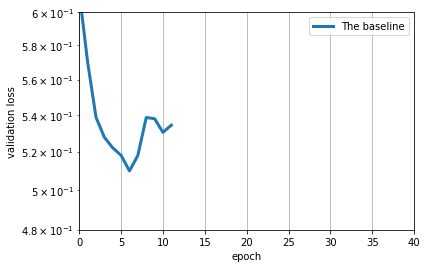

In [8]:
valid_loss1 = net1.history["val_loss"]
plt.plot(valid_loss1, linewidth=3, label="The baseline")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.xlim(0, 40)
plt.ylim(0.48, 0.6)
plt.yscale("log")
plt.show()

Note that optimal performance is often achieved around `epoch = 7`.
For later epochs the model is overfitting, and performance is worse.

# Increase dropout

Add some drop out to prevent overfitting.

In [9]:
increasedDropout = 0.4
model2 = getModel(increasedDropout)
net2 = model2.fit(X, y, epochs=12, batch_size=512, verbose=2,validation_split=0.2)

Train on 44702 samples, validate on 11176 samples
Epoch 1/12
 - 1s - loss: 1.0058 - accuracy: 0.6930 - val_loss: 0.6212 - val_accuracy: 0.7662
Epoch 2/12
 - 1s - loss: 0.6265 - accuracy: 0.7622 - val_loss: 0.5815 - val_accuracy: 0.7699
Epoch 3/12
 - 1s - loss: 0.5832 - accuracy: 0.7781 - val_loss: 0.5566 - val_accuracy: 0.7861
Epoch 4/12
 - 1s - loss: 0.5575 - accuracy: 0.7868 - val_loss: 0.5436 - val_accuracy: 0.7870
Epoch 5/12
 - 1s - loss: 0.5365 - accuracy: 0.7946 - val_loss: 0.5344 - val_accuracy: 0.7894
Epoch 6/12
 - 1s - loss: 0.5195 - accuracy: 0.8003 - val_loss: 0.5310 - val_accuracy: 0.7953
Epoch 7/12
 - 1s - loss: 0.5039 - accuracy: 0.8034 - val_loss: 0.5148 - val_accuracy: 0.8002
Epoch 8/12
 - 1s - loss: 0.4943 - accuracy: 0.8098 - val_loss: 0.5111 - val_accuracy: 0.8000
Epoch 9/12
 - 1s - loss: 0.4778 - accuracy: 0.8136 - val_loss: 0.5140 - val_accuracy: 0.7992
Epoch 10/12
 - 1s - loss: 0.4677 - accuracy: 0.8153 - val_loss: 0.5095 - val_accuracy: 0.8046
Epoch 11/12
 - 1s -

Compare validation loss for `net1` and `net2`

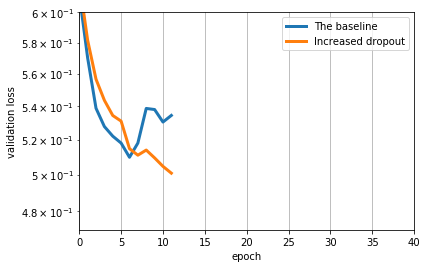

best validation loss 0.500865222346211


In [10]:
valid_loss2 = net2.history["val_loss"]
plt.plot(valid_loss1, linewidth=3, label="The baseline")
plt.plot(valid_loss2, linewidth=3, label="Increased dropout")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.xlim(0, 40)
plt.ylim(0.47, 0.6)
plt.yscale("log")
plt.show()
print('best validation loss', min(valid_loss2))

That is better. <br>
No more overfitting, and it feels like it is possible to increase number of epochs.

# Increase number of epochs

Increase number of epochs and check what loss can be reached.

In [11]:
model3 = getModel(increasedDropout)
net3 = model3.fit(X, y, epochs=25, batch_size=512, verbose=2, validation_split=0.2)

Train on 44702 samples, validate on 11176 samples
Epoch 1/25
 - 1s - loss: 1.0058 - accuracy: 0.6930 - val_loss: 0.6212 - val_accuracy: 0.7662
Epoch 2/25
 - 1s - loss: 0.6265 - accuracy: 0.7622 - val_loss: 0.5815 - val_accuracy: 0.7699
Epoch 3/25
 - 1s - loss: 0.5832 - accuracy: 0.7781 - val_loss: 0.5566 - val_accuracy: 0.7861
Epoch 4/25
 - 1s - loss: 0.5575 - accuracy: 0.7868 - val_loss: 0.5436 - val_accuracy: 0.7870
Epoch 5/25
 - 1s - loss: 0.5365 - accuracy: 0.7946 - val_loss: 0.5344 - val_accuracy: 0.7894
Epoch 6/25
 - 1s - loss: 0.5195 - accuracy: 0.8003 - val_loss: 0.5310 - val_accuracy: 0.7953
Epoch 7/25
 - 1s - loss: 0.5039 - accuracy: 0.8034 - val_loss: 0.5148 - val_accuracy: 0.8002
Epoch 8/25
 - 1s - loss: 0.4943 - accuracy: 0.8098 - val_loss: 0.5111 - val_accuracy: 0.8000
Epoch 9/25
 - 1s - loss: 0.4778 - accuracy: 0.8136 - val_loss: 0.5140 - val_accuracy: 0.7992
Epoch 10/25
 - 1s - loss: 0.4677 - accuracy: 0.8153 - val_loss: 0.5095 - val_accuracy: 0.8046
Epoch 11/25
 - 1s -

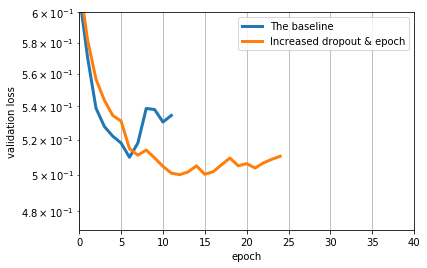

best validation loss 0.5000290817760449


In [12]:
valid_loss3 = np.array(net3.history["val_loss"])
plt.plot(valid_loss1, linewidth=3, label="The baseline")
plt.plot(valid_loss3, linewidth=3, label="Increased dropout & epoch")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.xlim(0, 40)
plt.ylim(0.47, 0.6)
plt.yscale("log")
plt.show()
print('best validation loss', min(valid_loss3))

Try to improve performance further by adding neurons

# Increase number of neurons

Increase number of neurons in the first hidden layer.

In [13]:
increasedNeurons1 = 1000
model4 = getModel(increasedDropout, neurons1=increasedNeurons1)
net4 = model4.fit(X, y, epochs=25, batch_size=512, verbose=2, validation_split=0.2)

Train on 44702 samples, validate on 11176 samples
Epoch 1/25
 - 2s - loss: 1.2508 - accuracy: 0.7044 - val_loss: 0.6234 - val_accuracy: 0.7654
Epoch 2/25
 - 2s - loss: 0.6110 - accuracy: 0.7692 - val_loss: 0.5684 - val_accuracy: 0.7809
Epoch 3/25
 - 2s - loss: 0.5671 - accuracy: 0.7826 - val_loss: 0.5409 - val_accuracy: 0.7925
Epoch 4/25
 - 2s - loss: 0.5386 - accuracy: 0.7931 - val_loss: 0.5341 - val_accuracy: 0.7959
Epoch 5/25
 - 2s - loss: 0.5153 - accuracy: 0.7991 - val_loss: 0.5268 - val_accuracy: 0.7898
Epoch 6/25
 - 2s - loss: 0.5002 - accuracy: 0.8055 - val_loss: 0.5168 - val_accuracy: 0.7957
Epoch 7/25
 - 2s - loss: 0.4810 - accuracy: 0.8148 - val_loss: 0.5084 - val_accuracy: 0.8026
Epoch 8/25
 - 2s - loss: 0.4618 - accuracy: 0.8185 - val_loss: 0.5042 - val_accuracy: 0.8042
Epoch 9/25
 - 2s - loss: 0.4528 - accuracy: 0.8217 - val_loss: 0.5078 - val_accuracy: 0.8024
Epoch 10/25
 - 2s - loss: 0.4394 - accuracy: 0.8268 - val_loss: 0.5023 - val_accuracy: 0.8063
Epoch 11/25
 - 2s -

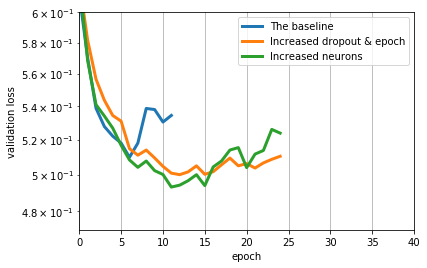

best validation loss 0.4930979978978506


In [14]:
valid_loss4 = net4.history["val_loss"]
plt.plot(valid_loss1, linewidth=3, label="The baseline")
plt.plot(valid_loss3, linewidth=3, label="Increased dropout & epoch")
plt.plot(valid_loss4, linewidth=3, label="Increased neurons")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.xlim(0, 40)
plt.ylim(0.47, 0.6)
plt.yscale("log")
plt.show()
print('best validation loss', min(valid_loss4))

That is better, but we start overfitting around epoch 12. <br>

# Decrease learning rate

To prevent overfitting decrease the learning rate.

In [15]:
model5 = getModel(increasedDropout, neurons1=increasedNeurons1, learningRate=0.008)
net5 = model5.fit(X, y, epochs=30, batch_size=512, verbose=2, validation_split=0.2)

Train on 44702 samples, validate on 11176 samples
Epoch 1/30
 - 2s - loss: 0.7756 - accuracy: 0.7183 - val_loss: 0.6112 - val_accuracy: 0.7734
Epoch 2/30
 - 2s - loss: 0.6081 - accuracy: 0.7687 - val_loss: 0.5769 - val_accuracy: 0.7802
Epoch 3/30
 - 2s - loss: 0.5773 - accuracy: 0.7783 - val_loss: 0.5599 - val_accuracy: 0.7836
Epoch 4/30
 - 2s - loss: 0.5548 - accuracy: 0.7874 - val_loss: 0.5509 - val_accuracy: 0.7870
Epoch 5/30
 - 2s - loss: 0.5386 - accuracy: 0.7920 - val_loss: 0.5402 - val_accuracy: 0.7912
Epoch 6/30
 - 2s - loss: 0.5299 - accuracy: 0.7959 - val_loss: 0.5365 - val_accuracy: 0.7902
Epoch 7/30
 - 2s - loss: 0.5170 - accuracy: 0.8005 - val_loss: 0.5293 - val_accuracy: 0.7942
Epoch 8/30
 - 2s - loss: 0.5074 - accuracy: 0.8026 - val_loss: 0.5243 - val_accuracy: 0.7940
Epoch 9/30
 - 2s - loss: 0.4995 - accuracy: 0.8054 - val_loss: 0.5276 - val_accuracy: 0.7960
Epoch 10/30
 - 2s - loss: 0.4931 - accuracy: 0.8095 - val_loss: 0.5201 - val_accuracy: 0.7996
Epoch 11/30
 - 2s -

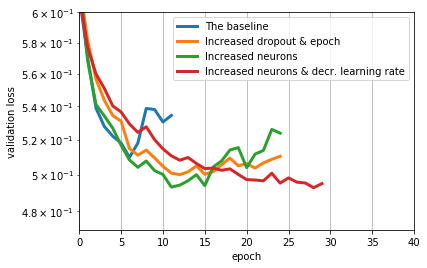

best validation loss 0.4927682465284999


In [16]:
valid_loss5 = net5.history["val_loss"]
plt.plot(valid_loss1, linewidth=3, label="The baseline")
plt.plot(valid_loss3, linewidth=3, label="Increased dropout & epoch")
plt.plot(valid_loss4, linewidth=3, label="Increased neurons")
plt.plot(valid_loss5, linewidth=3, label="Increased neurons & decr. learning rate")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.xlim(0, 40)
plt.ylim(0.47, 0.6)
plt.yscale("log")
plt.show()
print('best validation loss', min(valid_loss5))

Low learning rate smoothed down validation loss curve and improved prediction quality. 
Now there is a good balance between number of neurons, dropout and learning rate. <br>
Note that other parameters could have been tuned too: number of layers, activation function etc.

<font color=blue>
    
**Assignment 1**  <br>
Tune sequentially droput rate, number of epochs and number of neurons of the following network:

![test_model6](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FLecture%207%20AdvML%2Ftest_model6.png)

Try to improve 'best validation loss' at least by 0.02 compare to starting point (dropout rate = 0, optimizer=Adagrad(lr=0.04). <br>
Do not change validation_split=0.2, optimizer and learning rate. 

![TunningPic1](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FLecture%207%20AdvML%2FTunningPic1.png)

In [17]:
#Skipped code
# Assignment 1


# Tuning hyperparameters with grid search

Keras sequential models (single-input only) can be used in `scikit-learn` by wrapping them with the `KerasClassifier` or `KerasRegressor` class.

To use these wrappers define a function that creates and returns Keras sequential model, then pass this function to the `build_fn` argument when constructing `KerasClassifier` class. `build_fn` should construct, compile and return a Keras model, which will then be used to fit/predict. One of the following three values could be passed to build_fn:  

- A function
- An instance of a class that implements the call method
- None. This means you implement a class that inherits from either `KerasClassifier` or `KerasRegressor`. The call method of the present class will then be treated as the default `build_fn`.

E.g. we can create `KerasClassifier` instance with the above defined function `getModel` :

In [18]:
model = KerasClassifier(build_fn=getModel)

The constructor for the KerasClassifier class takes second argument   
`ssk_params`: model parameters & fitting parameters.  
We can pass there any legal model and fitting parameters. 

In [19]:
model = KerasClassifier(build_fn=getModel, epochs=20, batch_size=512, verbose=0)
model.get_params()

{'epochs': 20,
 'batch_size': 512,
 'verbose': 0,
 'build_fn': <function __main__.getModel(dropout=0.1, neurons1=500, neurons2=250, learningRate=0.04)>}

Since it is now scikit-learn Classifier, we can use Grid search - a model hyperparameter optimization technique provided in scikit-learn GridSearchCV class.  

When constructing this class we provide a dictionary of hyperparameters to evaluate in the `param_grid` argument.

By default, the grid search will only use one thread. <br>
By setting the `n_jobs` argument in the `GridSearchCV` constructor to -1, the process will use all cores on your machine. <br>
If `n_jobs` was set to a value higher than one, the data are copied for each point in the grid (but not `n_jobs` times). <br>
This is done for efficiency if individual jobs take very little time, but may raise errors if the dataset is large and there is not enough memory available. <br>
A workaround in this case is to set `pre_dispatch`. <br>
Then, the memory is copied only `pre_dispatch` number of times. <br>
A reasonable value for `pre_dispatch` is $2~\times~$n_jobs.

The `GridSearchCV` process will then construct and evaluate one model for each combination of parameters. <br>
Cross validation is used to evaluate each individual model (by default - 3-fold cross validation, this can be overridden by specifying the `cv` argument to the `GridSearchCV` constructor).  

We set "neg_log_loss" (negative logloss) as a scoring measure since  `GridSearchCV` is trying to maximize score.

In [20]:
# define the grid search parameters
param_grid = dict(dropout=[0.2, 0.3], neurons1=[300, 500])

grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    scoring="neg_log_loss", n_jobs=1)


In [21]:
grid_result = grid.fit(X, y)

/home/yuri/anaconda3/envs/tfspecial/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


We can extract results from `grid_result` attribute `cv_results_`. 

Recall that we were maximizing negative logloss. So, we output `-mean`  as logloss mean.

In [22]:
# summarize results
print("Best: %f using %s" % (-grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-mean, stdev, param))


Best: 0.523635 using {'dropout': 0.3, 'neurons1': 300}
0.543756 (0.001761) with: {'dropout': 0.2, 'neurons1': 300}
0.572386 (0.002783) with: {'dropout': 0.2, 'neurons1': 500}
0.523635 (0.003038) with: {'dropout': 0.3, 'neurons1': 300}
0.541836 (0.003278) with: {'dropout': 0.3, 'neurons1': 500}


# Selecting Optimization Algorithm

Grid search may be applied not only to numerical parameters. 

We can find the best optimizer using it.

In [23]:
def getModel1(dropout=0.1, neurons1=500, neurons2=250,optimizer="Adagrad"):
    np.random.seed(1)
    model = Sequential()
    model.add(Dense(neurons1, activation='relu', input_dim=num_features))
    model.add(Dropout(dropout))
    model.add(Dense(neurons2, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    return model


optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# create model
model = KerasClassifier(build_fn=getModel1, dropout=0.3, neurons1=300,
                        epochs=20, batch_size=512, verbose=0)
# define the grid search parameters

grid = GridSearchCV(estimator=model, param_grid=dict(optimizer=optimizer),
                    scoring="neg_log_loss",n_jobs=1)


In [24]:
grid_result = grid.fit(X, y)
# summarize results
print("Best: %f using %s" % (-grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-mean, stdev, param))

/home/yuri/anaconda3/envs/tfspecial/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best: 0.511791 using {'optimizer': 'Adam'}
0.746069 (0.002899) with: {'optimizer': 'SGD'}
0.515951 (0.003090) with: {'optimizer': 'RMSprop'}
0.521008 (0.002222) with: {'optimizer': 'Adagrad'}
0.519182 (0.001439) with: {'optimizer': 'Adadelta'}
0.511791 (0.003018) with: {'optimizer': 'Adam'}
0.517968 (0.001172) with: {'optimizer': 'Adamax'}
0.524609 (0.003715) with: {'optimizer': 'Nadam'}
